# KDE cluster maps for storm types

This notebook plots a number of KDE cluster maps for different variables for the classified storm dataset. The purpose is to demonstrate that the timeseries classification produces effective classification of the sotrm types - preferably better than can be achieved by any combination of the diagnostic variables alone. 

In [1]:
%matplotlib inline

import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np
from scipy.stats import gaussian_kde

In [3]:
BASEDIR = r"..\data"
ALLEVENTPATH = os.path.join(BASEDIR, "allevents", "results")
GUSTEVENTPATH = os.path.join(BASEDIR, "training", "gustratio")
fullStationFile = os.path.join(BASEDIR, "StationDetails.geojson")
allstndf = gpd.read_file(fullStationFile)
allstndf.set_index("stnNum", inplace=True)
allstndf['stnWMOIndex'] = allstndf['stnWMOIndex'].astype('Int64')

allStormData = pd.read_csv(os.path.join(ALLEVENTPATH, "storm_classification_wxcodes.csv"))
allStormData['datetimeUTC'] = pd.to_datetime(allStormData.datetimeUTC, format="%Y-%m-%d %H:%M:%S")
allStormData['date'] = allStormData.datetimeUTC.dt.date
allStormData['date'] = pd.to_datetime(allStormData['date'])

trainStormData = pd.read_csv(os.path.join(BASEDIR, "training", "visual_storm_types_datetime.csv"))
trainStormData['datetime'] = pd.to_datetime(trainStormData.datetime, format="%Y-%m-%d %H:%M:%S")
trainStormData['date'] = trainStormData.datetime.dt.date
trainStormData['date'] = pd.to_datetime(trainStormData['date'])

In [4]:
def loadGustRatioData(stnNum):
    fname = os.path.join(GUSTEVENTPATH, f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    df.set_index(['stnNum', 'date'], inplace=True)
    return df

grdflist = []
for stn in allstndf.index:
    try:
        df = loadGustRatioData(stn)
    except FileNotFoundError:
        pass
    else:
        grdflist.append(df)

allgrdf = pd.concat(grdflist)
allgrdf['idx'] = allgrdf.index

C:\Users\u12161\AppData\Local\Temp\ipykernel_10828\1824016357.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allgrdf = pd.concat(grdflist)


For now, we are excluding the anomalous events (spike and unclassfied).

In [5]:
allStormData = allStormData[~allStormData['stormType'].isin(['Spike', 'Unclassified'])]

In [10]:
compdf = pd.merge(allStormData.set_index(['stnNum', 'date']), allgrdf, left_index=True, right_index=True)
compdf['trend'] = (compdf['v2'] - compdf['v1'] ) / ((compdf['v1'] + compdf['v2']) / 2)

Preliminary inspection using `seaborn.jointplot()`. 

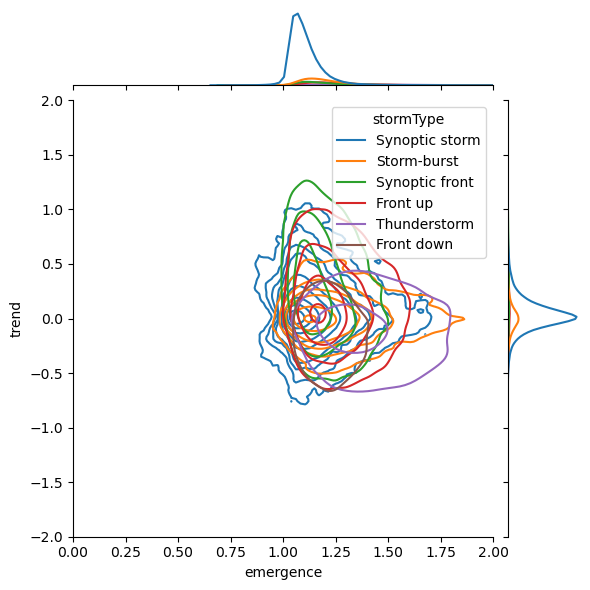

In [11]:
# Basic view - no fiddling with the color scheme or levels in the KDE plotting:
sns.jointplot(compdf, x='emergence', y='trend', hue='stormType', kind='kde', xlim=(0, 2), ylim=(-2, 2))


Calculate the KDE manually using `scipy.stats.gaussian_kde`. 

In [21]:
xgrid = np.arange(0.5, 2.01, 0.01)
ygrid = np.arange(-2.0, 2.01, 0.01)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

def calcKDE(df, xgrid, ygrid, stormType, xvar='emergence', yvar='trend'):
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kern = gaussian_kde(np.array(df.loc[df['stormType']==stormType, [xvar, yvar]].values.T, dtype=float))
    Z = np.reshape(kern(positions).T, X.shape)
    return Z

synZ = calcKDE(compdf, xgrid, ygrid, 'Synoptic storm')
syfZ = calcKDE(compdf, xgrid, ygrid, 'Synoptic front')
stbZ = calcKDE(compdf, xgrid, ygrid, 'Storm-burst')

tsZ = calcKDE(compdf, xgrid, ygrid, 'Thunderstorm')
fruZ = calcKDE(compdf, xgrid, ygrid, 'Front up')
frdZ = calcKDE(compdf, xgrid, ygrid, 'Front down')


Calculate the location of the maxima (in grid points)

In [22]:
synIdxMax = np.unravel_index(np.argmax(synZ, axis=None), synZ.shape)
syfIdxMax = np.unravel_index(np.argmax(syfZ, axis=None), syfZ.shape)
stbIdxMax = np.unravel_index(np.argmax(stbZ, axis=None), stbZ.shape)
tsIdxMax = np.unravel_index(np.argmax(tsZ, axis=None), tsZ.shape)
fruIdxMax = np.unravel_index(np.argmax(fruZ, axis=None), fruZ.shape)
frdIdxMax = np.unravel_index(np.argmax(frdZ, axis=None), frdZ.shape)

Plot the KDE, adding labels for the peak of each storm type (numbered 1-6)

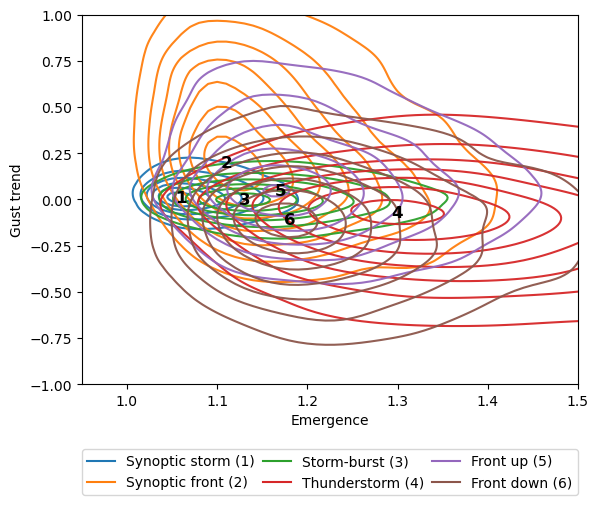

In [23]:
pal = sns.color_palette(as_cmap=True)
fig, ax = plt.subplots()
ax.contour(X, Y, synZ, colors=pal[0], levels=7, alpha=0.95)
ax.contour(X, Y, syfZ, colors=pal[1], levels=7, alpha=0.95)
ax.contour(X, Y, stbZ, colors=pal[2], levels=7, alpha=0.95)

ax.contour(X, Y, tsZ, colors=pal[3], levels=7, alpha=0.95)
ax.contour(X, Y, fruZ, colors=pal[4], levels=7, alpha=0.95)
ax.contour(X, Y, frdZ, colors=pal[5], levels=7, alpha=0.95)

kwargs = {"ha": "center",
          "va": "center",
          "fontweight": "bold",
          "fontsize": "large"}
ax.text(xgrid[synIdxMax[1]], ygrid[synIdxMax[0]], s="1", **kwargs)
ax.text(xgrid[syfIdxMax[1]], ygrid[syfIdxMax[0]], s="2", **kwargs)
ax.text(xgrid[stbIdxMax[1]], ygrid[stbIdxMax[0]], s="3", **kwargs)

ax.text(xgrid[tsIdxMax[1]], ygrid[tsIdxMax[0]], s="4", **kwargs)
ax.text(xgrid[fruIdxMax[1]], ygrid[fruIdxMax[0]], s="5", **kwargs)
ax.text(xgrid[frdIdxMax[1]], ygrid[frdIdxMax[0]], s="6", **kwargs)


ax.set_xlim((0.95, 1.5))
ax.set_ylim((-1.0, 1.0))
ax.set_xlabel("Emergence")
ax.set_ylabel("Gust trend")

# Now do the legend:
lines = []
stormTypes = ['Synoptic storm', 'Synoptic front', 'Storm-burst',
              'Thunderstorm','Front up', 'Front down']
for i, label in enumerate(stormTypes):
    l = mlines.Line2D([], [], color=pal[i], label=f"{label} ({i+1})")
    lines.append(l)

ax.legend(handles=lines, bbox_to_anchor=(0., -.3, 1., .102), loc='lower center',
                      ncols=3, mode="expand", borderaxespad=0.)
plt.savefig(os.path.join(ALLEVENTPATH, "emergence_trend_kde_allevents.jpg"), dpi=600, bbox_inches="tight")

Now repeat for the training set only

In [16]:
trainStormData.set_index(['stnNum', 'date'], inplace=True)
allStormData.set_index(['stnNum', 'date'], inplace=True)

In [19]:
trainEvents = allStormData.loc[allStormData.index.isin(trainStormData.index)]
compTraindf = pd.merge(trainEvents, allgrdf, left_index=True, right_index=True)
compTraindf['trend'] = (compTraindf['v2'] - compTraindf['v1'] ) / ((compTraindf['v1'] + compTraindf['v2']) / 2)

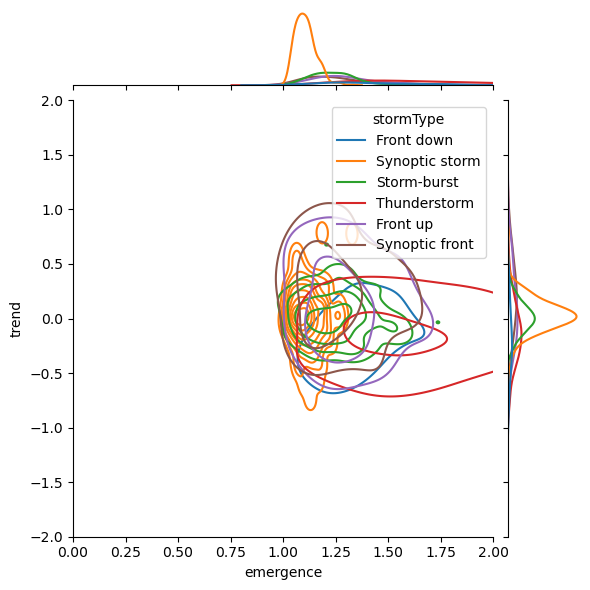

In [20]:
# Basic view - no fiddling with the color scheme or levels in the KDE plotting:
sns.jointplot(compTraindf, x='emergence', y='trend', hue='stormType', kind='kde', xlim=(0, 2), ylim=(-2, 2))

In [24]:
synZ = calcKDE(compTraindf, xgrid, ygrid, 'Synoptic storm')
syfZ = calcKDE(compTraindf, xgrid, ygrid, 'Synoptic front')
stbZ = calcKDE(compTraindf, xgrid, ygrid, 'Storm-burst')

tsZ = calcKDE(compTraindf, xgrid, ygrid, 'Thunderstorm')
fruZ = calcKDE(compTraindf, xgrid, ygrid, 'Front up')
frdZ = calcKDE(compTraindf, xgrid, ygrid, 'Front down')

synIdxMax = np.unravel_index(np.argmax(synZ, axis=None), synZ.shape)
syfIdxMax = np.unravel_index(np.argmax(syfZ, axis=None), syfZ.shape)
stbIdxMax = np.unravel_index(np.argmax(stbZ, axis=None), stbZ.shape)
tsIdxMax = np.unravel_index(np.argmax(tsZ, axis=None), tsZ.shape)
fruIdxMax = np.unravel_index(np.argmax(fruZ, axis=None), fruZ.shape)
frdIdxMax = np.unravel_index(np.argmax(frdZ, axis=None), frdZ.shape)

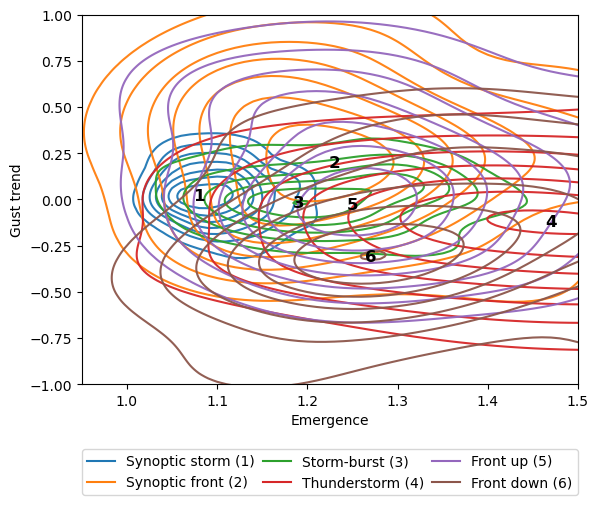

In [25]:
pal = sns.color_palette(as_cmap=True)
fig, ax = plt.subplots()
ax.contour(X, Y, synZ, colors=pal[0], levels=7, alpha=0.95)
ax.contour(X, Y, syfZ, colors=pal[1], levels=7, alpha=0.95)
ax.contour(X, Y, stbZ, colors=pal[2], levels=7, alpha=0.95)

ax.contour(X, Y, tsZ, colors=pal[3], levels=7, alpha=0.95)
ax.contour(X, Y, fruZ, colors=pal[4], levels=7, alpha=0.95)
ax.contour(X, Y, frdZ, colors=pal[5], levels=7, alpha=0.95)

kwargs = {"ha": "center",
          "va": "center",
          "fontweight": "bold",
          "fontsize": "large"}
ax.text(xgrid[synIdxMax[1]], ygrid[synIdxMax[0]], s="1", **kwargs)
ax.text(xgrid[syfIdxMax[1]], ygrid[syfIdxMax[0]], s="2", **kwargs)
ax.text(xgrid[stbIdxMax[1]], ygrid[stbIdxMax[0]], s="3", **kwargs)

ax.text(xgrid[tsIdxMax[1]], ygrid[tsIdxMax[0]], s="4", **kwargs)
ax.text(xgrid[fruIdxMax[1]], ygrid[fruIdxMax[0]], s="5", **kwargs)
ax.text(xgrid[frdIdxMax[1]], ygrid[frdIdxMax[0]], s="6", **kwargs)


ax.set_xlim((0.95, 1.5))
ax.set_ylim((-1.0, 1.0))
ax.set_xlabel("Emergence")
ax.set_ylabel("Gust trend")

# Now do the legend:
lines = []
stormTypes = ['Synoptic storm', 'Synoptic front', 'Storm-burst',
              'Thunderstorm','Front up', 'Front down']
for i, label in enumerate(stormTypes):
    l = mlines.Line2D([], [], color=pal[i], label=f"{label} ({i+1})")
    lines.append(l)

ax.legend(handles=lines, bbox_to_anchor=(0., -.3, 1., .102), loc='lower center',
                      ncols=3, mode="expand", borderaxespad=0.)
plt.savefig(os.path.join(ALLEVENTPATH, "emergence_trend_kde_trainevents.jpg"), dpi=600, bbox_inches="tight")